In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from keras.layers import LSTM, RepeatVector, TimeDistributed

In [2]:
dataframe = pd.read_csv('../datasets/Plasma current.csv',usecols=[1]).clip(lower=0).astype('float32')
dataframe = dataframe[:200]

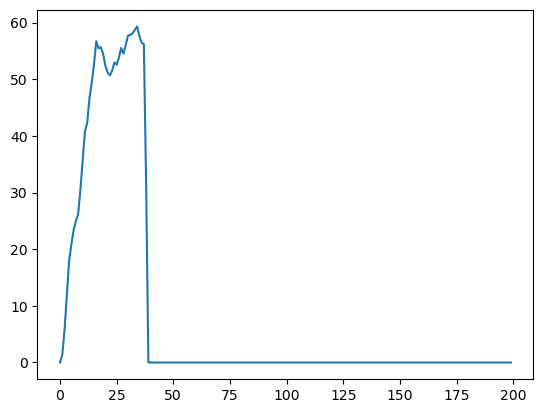

In [3]:
plt.plot(dataframe[:8000])

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataframe)

In [5]:
dataset.shape

(200, 1)

In [6]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
test.shape

(40, 1)

In [7]:
train.shape

(160, 1)

In [8]:
def to_sequences(dataset, time_window,output):
    x = []
    y = []

    for i in range(len(dataset)-time_window-1-output):
        #print(i)
        window = dataset[i:(i+time_window), 0]
        x.append(window)
        y.append(dataset[i+time_window:i+time_window+output, 0])

    return np.array(x),np.array(y)

In [9]:
def to_sequences2(dataset, time_window):
    x = []
    y = []

    for i in range(len(dataset)-time_window-1-output):
        #print(i)
        window = dataset[i:(i+time_window), 0]
        x.append(window)
        y.append(dataset[i+time_window, 0])

    return np.array(x),np.array(y)

In [10]:
time_window = 10
output=1  # Number of time steps to look back
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, time_window, output)
testX, testY = to_sequences(test, time_window,output)

In [11]:
trainX.shape

(148, 10)

In [12]:
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
print(trainX.shape)
testX= testX.reshape((testX.shape[0], testX.shape[1], 1))
print(testX.shape)
trainY = trainY.reshape((trainY.shape[0], 1))
print(trainY.shape)
testY= testY.reshape((testY.shape[0], 1))
print(testY.shape)

(148, 10, 1)
(28, 10, 1)
(148, 1)
(28, 1)


In [13]:
trainY.shape

(148, 1)

In [14]:
from statsmodels.tsa.seasonal import STL

import tensorflow as tf
import keras
from keras.layers import Dense
import pandas as pd
import numpy as np


class _CRUCell(keras.layers.Layer):

    def __init__(self, in_dim, hid_dim, bias=True):
        super(_CRUCell, self).__init__()

        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.bias = bias


        self.wx_t = Dense(units=self.hid_dim*3)
        self.wx_s = Dense(units= self.hid_dim*3)
        self.wx_r = Dense(units=self.hid_dim)


        self.wh_t = Dense(self.hid_dim*3, bias_initializer='zeros')
        self.wh_s = Dense(self.hid_dim*3, bias_initializer='zeros')
        self.wh_r = Dense( self.hid_dim, bias_initializer='zeros')

        self.reset_parameters()

    def call(self, x, hid_state = None):

        lamda = 0.5
        # print(x.shape)
        x_t, x_s, x_r = self.ts_decompose(x)

        if hid_state is None:
            hid_state = tf.zeros(3, x.shape[1], self.hid_dim)

        x_t = self.wx_t(x_t)
        x_s = self.wx_s(x_s)
        x_r = self.wx_r(x_r)
        # print(x_t.shape)

        h_t = self.wh_t(hid_state[0,:,:])
        h_s = self.wh_s(hid_state[1,:,:])

        x_autocor_t, x_cor_t, x_new_t = tf.split(x_t, num_or_size_splits=3, axis=1)
        x_autocor_s, x_cor_s, x_new_s = tf.split(x_s, num_or_size_splits=3, axis=1)
        h_autocor_t, h_cor_t, h_new_t = tf.split(h_t, num_or_size_splits=3, axis=1)
        h_autocor_s, h_cor_s, h_new_s = tf.split(h_s, num_or_size_splits=3, axis=1)

        autocor_t = tf.sigmoid(x_autocor_t + h_autocor_t)
        autocor_s = tf.sigmoid(x_autocor_s + h_autocor_s)

        cor_t = tf.sigmoid(x_cor_t + h_cor_s)
        cor_s = tf.sigmoid(x_cor_s + h_cor_t)

        new_t = lamda*tf.tanh(x_new_t + (autocor_t * h_new_t)) + (1-lamda)*tf.tanh(x_new_t + (cor_t * h_new_s))
        new_s = lamda*tf.tanh(x_new_s + (autocor_s * h_new_s)) + (1-lamda)*tf.tanh(x_new_s + (cor_s * h_new_t))

        # print(x_r.shape)
        new_state = tf.concat([tf.expand_dims(new_t, axis=0),
                       tf.expand_dims(new_s, axis=0),
                       tf.expand_dims(tf.tanh(x_r), axis=0)], axis=0)


        hid_state = tf.tensor_scatter_nd_update(hid_state, [[0], [1], [2]], new_state)

        return hid_state

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hid_dim)
        for w in self.trainable_variables:
            w.assign(tf.random.uniform(shape=w.shape, minval=-std, maxval=std))

    def ts_decompose(self, x):
        
        x = pd.DataFrame(x.numpy())
        dates = pd.date_range('01-01-01', periods = len(x), freq='D')
        x.index = dates
        trend = []
        seasonal = []
        resid = []
        for i in range(len(x.columns)):
            stl = STL(x[i])
            res = stl.fit()
            trend.append(res.trend.values)
            seasonal.append(res.seasonal.values)
            resid.append(res.resid.values)

        trend = np.array(trend)
        seasonal = np.array(seasonal)
        resid = np.array(resid)

        trend = tf.transpose(tf.convert_to_tensor(trend), perm=[1, 0])
        seasonal = tf.transpose(tf.convert_to_tensor(seasonal), perm=[1, 0])
        resid = tf.transpose(tf.convert_to_tensor(resid), perm=[1, 0])

        return trend, seasonal, resid

In [15]:
# import model.CRUCell as CRUCell
import keras
import tensorflow as tf

class _CRU(keras.layers.Layer):

    def __init__(self, in_dim, hid_dim, out_dim, num_layers, bias = True):
        super(_CRU, self).__init__()

        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.num_layers = num_layers

        self.bias = bias
        self.out_dim = out_dim


        self.fc= keras.Sequential([
            Dense(self.out_dim)
        ])



    def build(self,input_shape):

        self.cell_list = []
        self.cell_list.append(_CRUCell(in_dim=self.in_dim, hid_dim=self.hid_dim, bias=self.bias))

        for l in range(1, self.num_layers):
            self.cell_list.append(_CRUCell(in_dim=self.in_dim, hid_dim=self.hid_dim, bias=self.bias))

    def call(self, input, hid_state=None):

        if hid_state is None:
            hid_state = tf.zeros((self.num_layers, 3, input.shape[0] ,self.hid_dim), dtype=tf.float32)


        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append(hid_state[layer,:, :, :])

        for t in range(input.shape[1]):

            for layer in range(self.num_layers):

                if layer == 0:
                    hid_layer = self.cell_list[layer](input[:, t, :], hidden[layer])
                else:
                    hid_layer = self.cell_list[layer](hidden[layer - 1],hidden[layer])

                hidden[layer] = hid_layer

            outs.append(hid_layer)

        feature = tf.reduce_mean(outs[-1],axis=1)
        out = tf.reduce_sum(outs[-1],axis=0)
        # out = out.numpy().reshape(out.shape[0],out.shape[1],1)
        # print(type(out))
        out = self.fc(out)

        return out, feature

In [16]:
# import Preprocessing
# import model.CRU as cru
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
import numpy as np

class ModelTrain():

    def __init__(self, time_window, forecasting_term):

        self.in_dim = time_window

    def _fit(self, hid_dim, out_dim, num_layers, epoch):

        m  = _CRU(self.in_dim, hid_dim, out_dim, num_layers)

        crit = tf.keras.losses.MeanSquaredError()

        optimizer = tf.keras.optimizers.Adam(0.001)

        for e in range(epoch):
            with tf.GradientTape() as tape:
                trainPredict, _ = m(trainX)
                loss = crit(trainPredict, trainY)
            gradients = tape.gradient(loss, m.trainable_variables)
            optimizer.apply_gradients(zip(gradients, m.trainable_variables))

            if (e+1) % 100 == 0:

                testPredict,_ = m(testX)
                traindata = trainY2.reshape(trainY2.shape[0],trainY.shape[1])
                testdata = testY.reshape(testY.shape[0],testY.shape[1])

                testPredict = scaler.inverse_transform(testPredict.numpy().reshape(testPredict.shape[0],testPredict.shape[1]))
                trainPredict = scaler.inverse_transform(trainPredict.numpy().reshape(trainPredict.shape[0],trainPredict.shape[1]))
                testdata = scaler.inverse_transform(testdata)
                traindata = scaler.inverse_transform(traindata)

                test_rmse =  math.sqrt(mse(testPredict, testdata))
                train_rmse = math.sqrt(mse(trainPredict, traindata))

                print('[Epoch: {}/{}] [Train RMSE: {}] [Test RMSE: {}]'.format(
                    e+1, epoch, str(train_rmse)[:6], str(test_rmse)[:6]))

        return m,traindata,trainPredict,testdata,testPredict

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
if __name__ == '__main__':

    # Data Preprocessing
    time_window = 10
    forecasting_term = 1

    hid_dim = 10

    out_dim = 1
    num_layers = 1
    epoch = 200

    model = ModelTrain(time_window ,forecasting_term)
    m,traindata,trainPredict,testdata,testPredict  = model._fit(hid_dim, out_dim, num_layers, epoch)

C:\Users\techno\anaconda3\Lib\site-packages\keras\src\layers\layer.py:360: UserWarning: `build()` was called on layer '_cru_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
trainX.shape

In [ ]:
traindata[:3]

In [ ]:
trainPredict[:3]

In [ ]:
dataset = scaler.inverse_transform(dataset)

In [ ]:
# plt.plot(dataset)
plt.plot(traindata[2000:2500],color='r')
plt.plot(trainPredict[2000:2500])

In [ ]:
x_data=np.linspace(0,testY.shape[0], num=testY.shape[0])
plt.plot(x_data[:1000], testdata[0:1000], label='actual',color='r')
plt.plot(x_data[0:1000], testPredict[:1000], label='predicted')

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
import math

In [ ]:
math.sqrt(mean_squared_error(traindata,trainPredict))

In [ ]:
math.sqrt(mean_squared_error(testdata,testPredict))